In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

from utils import retrieve_data_orientation, circular_encoding

### Plot Arguments

In [2]:
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

### Load Data

In [3]:
dat = retrieve_data_orientation()
cdepths = np.load('./data/all_depths.npy',allow_pickle=True)

dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

### Split Neuron Layer

Because we're investigating neurons by layer, it is helpful to first investigate the layers and split neurons by assigning them labels.

In [4]:
gather_lengths = []
for i in range(cdepths.shape[0]):
  gather_lengths.append(cdepths[i].shape[0])

print('avg number of neurons per session:', np.mean(gather_lengths))

avg number of neurons per session: 18496.09375


Text(0, 0.5, 'cortical depth')

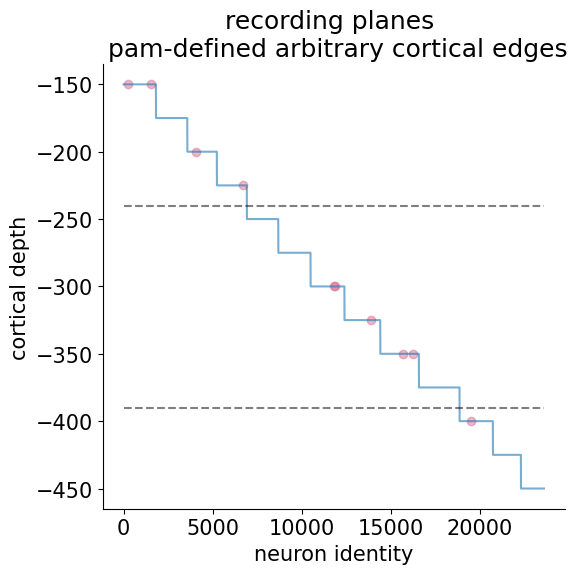

In [5]:
session = 0

_, _, z = dat['xyz'] #position coordinates per neuron

fig = plt.figure(figsize=(6,6))

plt.plot(-cdepths[session],alpha=0.6)
plt.hlines(y = -240,
           xmin = 0,
           xmax = cdepths[session].shape,
           color='k', linestyle='--',
           alpha=0.5
           )
plt.hlines(y = -390,
           xmin = 0,
           xmax = cdepths[session].shape,
           color='k', linestyle='--',
           alpha=0.5
           )

#plot the depths of a couple of randomly sampled neurons
idx_list = np.random.choice(cdepths[session].shape[0], 10)
for i in idx_list:
  plt.scatter(i,z[i],color='palevioletred',alpha=0.5)

plt.title('recording planes \n pam-defined arbitrary cortical edges')
plt.xlabel('neuron identity')
plt.ylabel('cortical depth')

For now, define the edges of each layer arbitrarily, just to get the labeling code running, then revise!

Update: Josien said edges typically are:
* layer 2/3 up to -250 um
* layer 4 between -250 to -370 um
* layer 5 below this

In [6]:
layer_labels = ['2/3', '4', '5']
gather_layers = []

for i in z:
  if (i <= -150) & (i >= -240):
    gather_layers.append(layer_labels[0])

  elif (i < -240) & (i >= -370):
    gather_layers.append(layer_labels[1])

  elif i < -370:
    gather_layers.append(layer_labels[2])

dat['layer_labels'] = np.asarray(gather_layers)
print('layer labels:', np.unique(dat['layer_labels']))
print('layer shape:', dat['layer_labels'].shape)

layer labels: ['2/3' '4' '5']
layer shape: (23589,)


In [7]:
print(np.where(dat['layer_labels'] == '2/3'))
print(f'number of 2/3 neurons: {np.where(dat["layer_labels"] == "2/3")[0].shape[0]}')
print(np.where(dat['layer_labels'] == '4'))
print(f'number of 4 neurons: {np.where(dat["layer_labels"] == "4")[0].shape[0]}')
print(np.where(dat['layer_labels'] == '5'))
print(f'number of 5 neurons: {np.where(dat["layer_labels"] == "5")[0].shape[0]}')

(array([   0,    1,    2, ..., 6913, 6914, 6915], dtype=int64),)
number of 2/3 neurons: 6916
(array([ 6916,  6917,  6918, ..., 16567, 16568, 16569], dtype=int64),)
number of 4 neurons: 9654
(array([16570, 16571, 16572, ..., 23586, 23587, 23588], dtype=int64),)
number of 5 neurons: 7019


Wait, so the neurons order does matter! It looks like neurons 0-6915 are in layer 2/3, neurons 6916-16569 are in layer 4, and neurons 16570-23588 are in layer 5.

### Process Orientation Data

For each trials, the subject is shown an orientation ranging from 0-2pi rad. This data is not very helpful for us because 0 and 2pi are technically the same angle. We want to preprocess the orientation data to reflect that. Specifically, we will map each angle to a Cartesian coordinate, with x and y that are all equidistant from the center. In other words, we plot (1, angle) in polar coordinates.

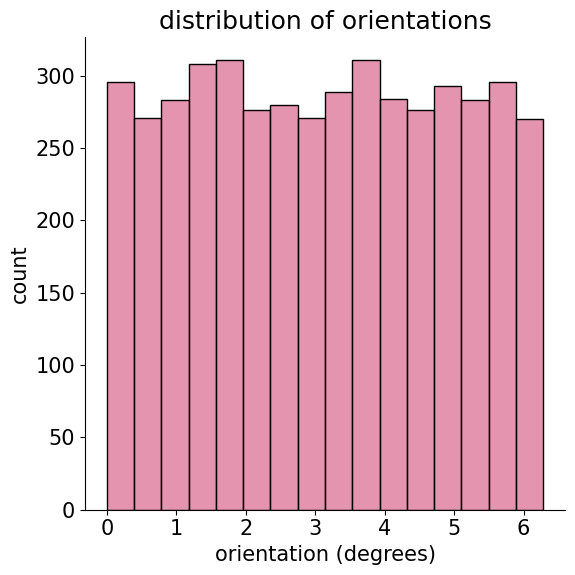

In [8]:
#plot the distribution of orientations
plt.figure(figsize=(6,6))
sns.histplot(dat['istim'], bins=16, color='palevioletred')
plt.title('distribution of orientations')
plt.xlabel('orientation (degrees)')
plt.ylabel('count')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


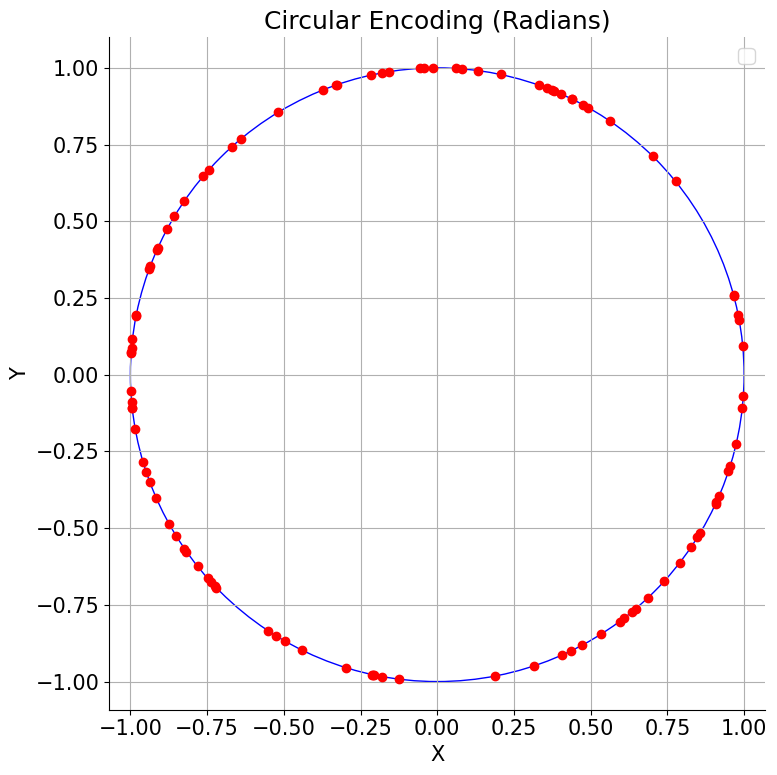

In [9]:
# Create the plot
plt.figure(figsize=(8, 8))

# Plot the unit circle
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)

random_angles = np.random.choice(dat['istim'], 100)

for angle in random_angles:
    x, y = circular_encoding(angle)
    plt.plot(x, y, 'ro')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Circular Encoding (Radians)')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


In [10]:
istim_x = np.zeros(dat['istim'].shape)
istim_y = np.zeros(dat['istim'].shape)

for idx, ori in enumerate(dat['istim']):
    x, y = circular_encoding(ori)
    istim_x[idx] = x
    istim_y[idx] = y


dat['istim_x'] = istim_x
dat['istim_y'] = istim_y

This is one way... but I think I have a better idea!

If we just run the angle through cosine, closer angles will be closer in value to each others! cos(0) and cos(2pi) are both 1.

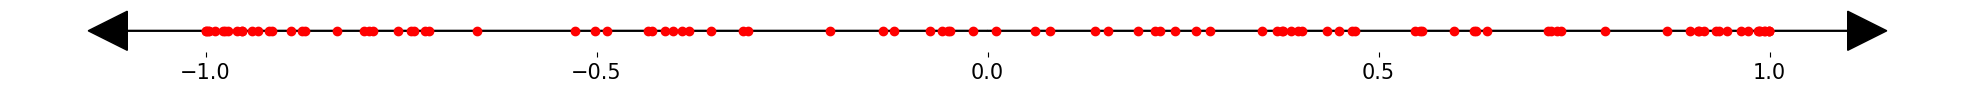

In [11]:
# Create the plot
# Create a figure and an axis
fig, ax = plt.subplots()

# Set the axis limits
ax.set_xlim(-1.25, 1.25)

# Remove y-axis
ax.get_yaxis().set_visible(False)
# Center x-axis
ax.set_aspect('equal')

# add arrows
ax.arrow(0, 0, 1.1, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')
ax.arrow(0, 0, -1.1, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

# remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

random_angles = np.random.choice(dat['istim'], 100)

for angle in random_angles:
    cosine_value = np.cos(angle)
    plt.plot(cosine_value, 0, marker='o', color='red')

plt.show()

In [12]:
dat['istim_cos'] = np.cos(dat['istim'])

This way, we can actually use a DecisionTree (regressor or classifier) to predict the angles instead. However, this "squishing" of dimension means we "lose" directionality from the data. Cosine angles being close to each other now only mean they have approximately the same orientation, not direction. This might be useful for training models specifically for orientation neurons.

With the circular encoding data having 2 data points instead of 1, we either have to have 2 DecisionTrees training at the same time (1 for x, 1 for y), or a neural net.

### Training time!!!

For now, I'm using regular angle data from `dat['istim']`.

#### Preparing Data

In [13]:
angles = np.arange(0, 2 * np.pi, (2 * np.pi) / 32)
angles = np.append(angles, 2 * np.pi)
angles_dict = {}

for i in range(32):
  angles_dict[i] = (angles[i], angles[i + 1])

dat['ori'] = np.array([])

for i in range(len(dat['istim'])):
  for j in range(32):
    if dat['istim'][i] >= angles_dict[j][0] and dat['istim'][i] <= angles_dict[j][1]:
      dat['ori'] = np.append(dat['ori'], j)

In [14]:
sresp_df = pd.DataFrame(dat['sresp'].T)
sresp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23579,23580,23581,23582,23583,23584,23585,23586,23587,23588
0,53.483261,20.518503,0.000000,578.916809,1.836931,568.025085,208.385452,10.627718,0.000000,914.985901,...,0.713030,13.767550,0.000000,12.340549,10.835267,0.000000,3.518415,0.00000,16.479868,7.973795
1,63.134762,2.379957,0.000000,14.064929,6.834842,661.878601,85.330322,0.000000,0.000000,238.626938,...,0.572336,1.329864,0.000000,0.000000,0.000000,0.000000,4.695301,0.00000,0.000000,0.000000
2,62.432125,0.000000,0.000000,0.000000,12.260544,767.102600,52.511433,0.000000,0.000000,155.803101,...,0.690646,0.000000,10.962273,4.433188,6.063787,5.905285,0.000000,4.99042,5.061645,31.222448
3,156.087830,0.000000,6.526441,586.897522,2.147522,82.771744,365.861115,0.000000,41.978580,0.000000,...,0.657146,2.781556,0.000000,0.000000,0.000000,2.372391,0.000000,0.00000,0.000000,0.000000
4,374.028961,5.017585,1.136153,20.846800,0.000000,224.130447,6.452364,0.167832,772.317444,0.000000,...,0.000000,0.120470,0.000000,0.000000,0.637336,11.290267,0.000000,0.00000,0.000000,0.000000


In [15]:
sresp_2_3_df = sresp_df[np.where(dat['layer_labels'] == '2/3')[0]]
sresp_4_df = sresp_df[np.where(dat['layer_labels'] == '4')[0]]
sresp_5_df = sresp_df[np.where(dat['layer_labels'] == '5')[0]]

# test to see if the dataframe columns match the np.where indices
print(f'2/3 df columns match indices: {np.all(sresp_2_3_df.columns == np.where(dat["layer_labels"] == "2/3")[0])}')
print(f'4 df columns match indices: {np.all(sresp_4_df.columns == np.where(dat["layer_labels"] == "4")[0])}')
print(f'5 df columns match indices: {np.all(sresp_5_df.columns == np.where(dat["layer_labels"] == "5")[0])}')

2/3 df columns match indices: True
4 df columns match indices: True
5 df columns match indices: True


In [16]:
X_train, X_test, y_train, y_test = train_test_split(sresp_df, dat['ori'], test_size=0.2, random_state=1)
X_2_3_train, X_2_3_test, y_2_3_train, y_2_3_test = train_test_split(sresp_2_3_df, dat['ori'], test_size=0.2, random_state=1)
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(sresp_4_df, dat['ori'], test_size=0.2, random_state=1)
X_5_train, X_5_test, y_5_train, y_5_test = train_test_split(sresp_5_df, dat['ori'], test_size=0.2, random_state=1)

#### Training

In [24]:
def get_confusion_matrix(X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array) -> ConfusionMatrixDisplay:
    """
    Get confusion matrix for classification model.

    Args:
        model: trained classification model
        X (np.array): input data
        y (np.array): target data

    Returns:
        disp: confusion matrix display
    """
    model = DecisionTreeClassifier(random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    return disp

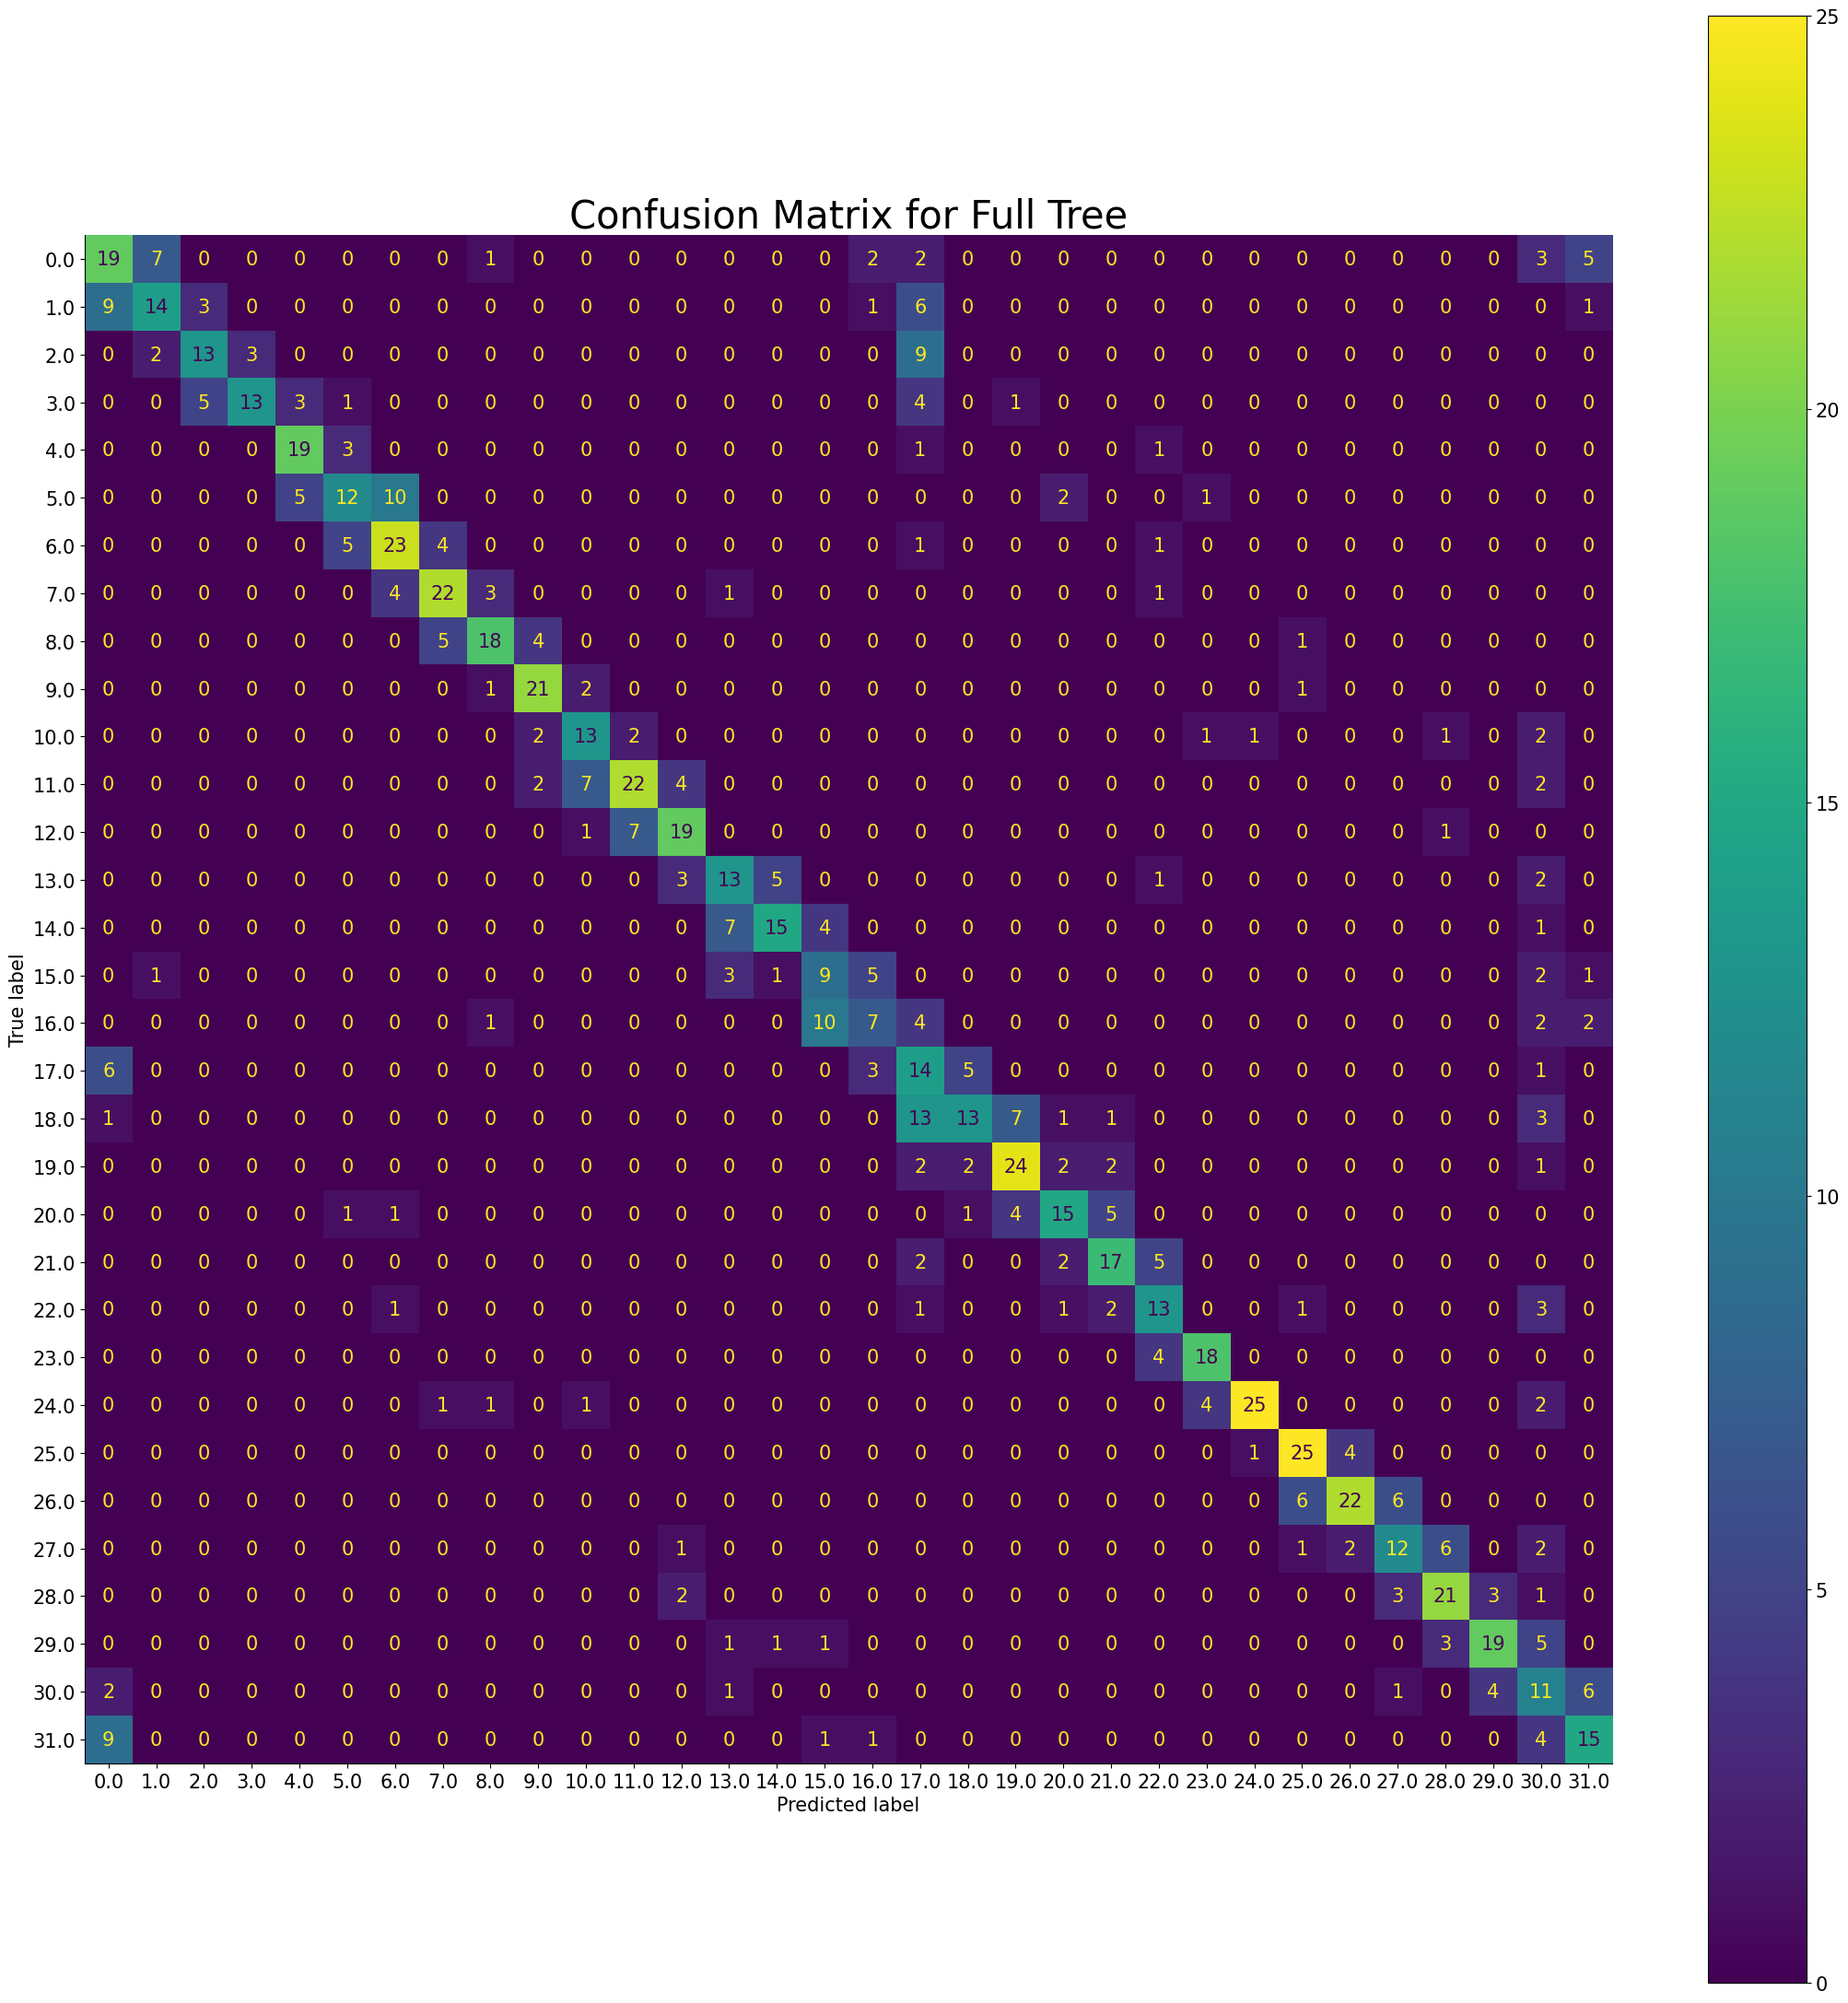

In [25]:
fig, ax = plt.subplots(figsize=(22, 22))
disp = get_confusion_matrix(X_train, y_train, X_test, y_test)
disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='horizontal')
plt.title('Confusion Matrix for Full Tree', fontsize=30)
plt.show()

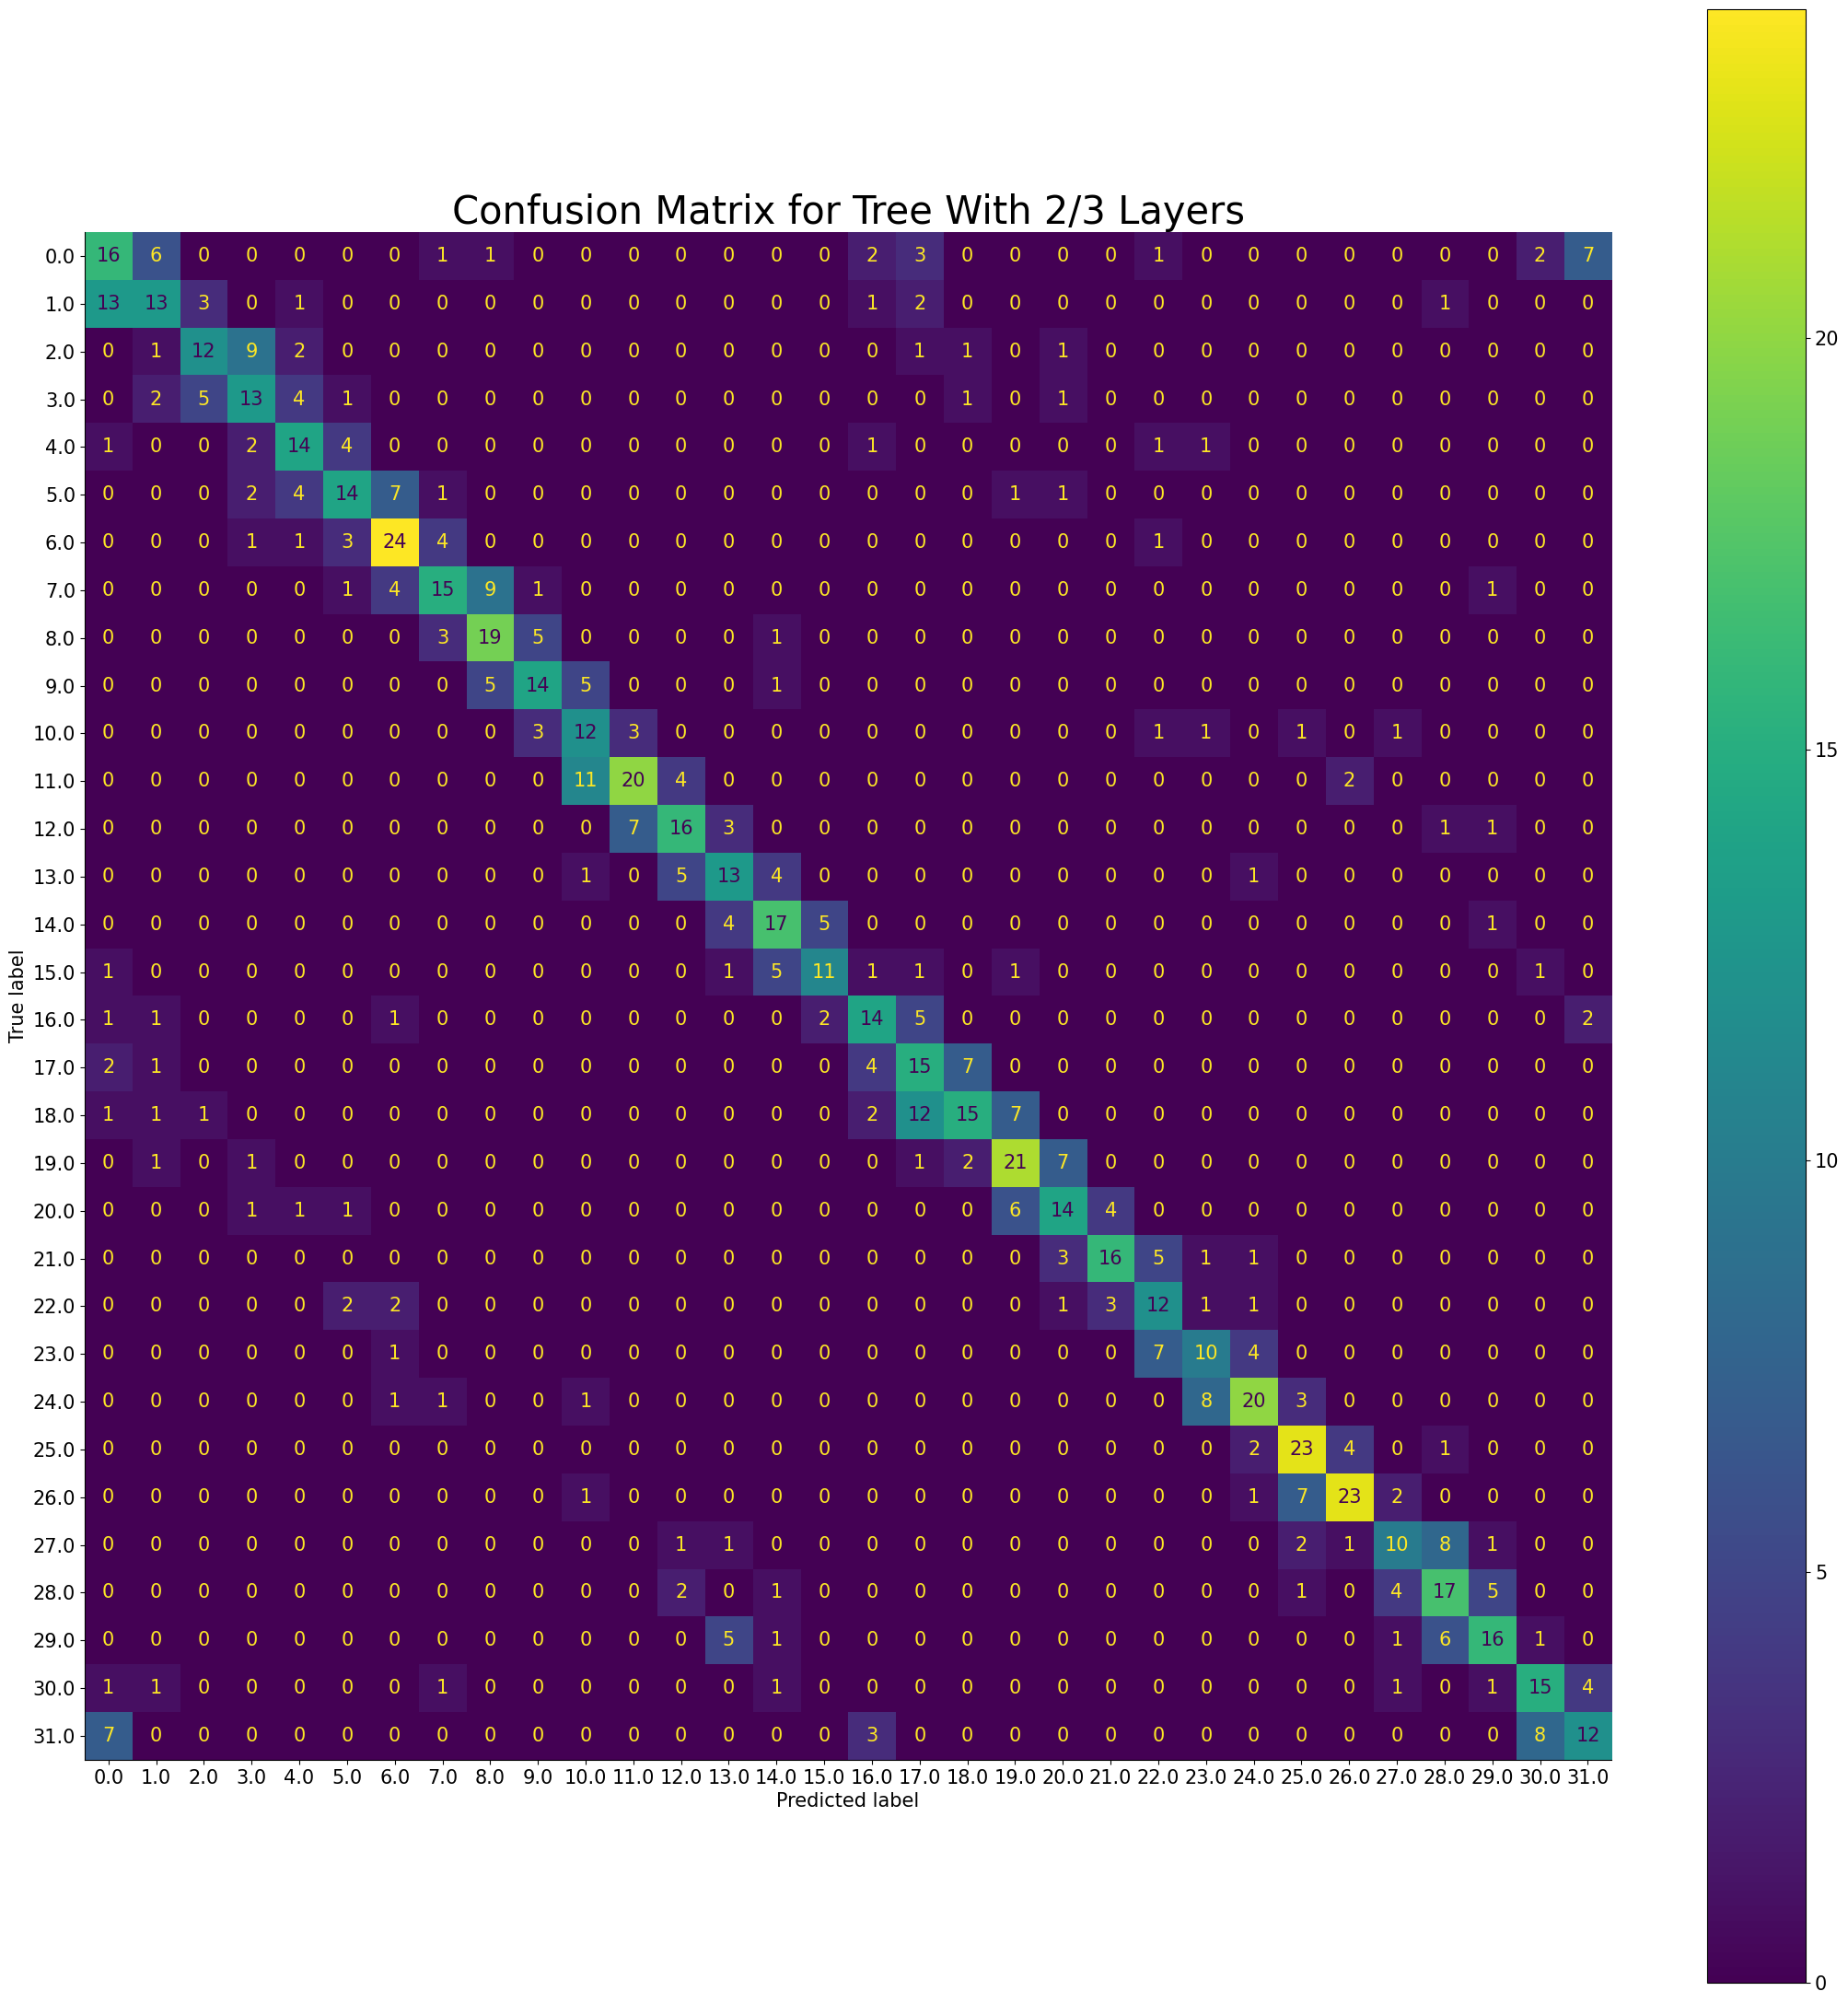

In [19]:
fig, ax = plt.subplots(figsize=(22, 22))
disp = get_confusion_matrix(X_2_3_train, y_2_3_train, X_2_3_test, y_2_3_test)
disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='horizontal')
plt.title('Confusion Matrix for Tree With 2/3 Layers', fontsize=30)
plt.show()

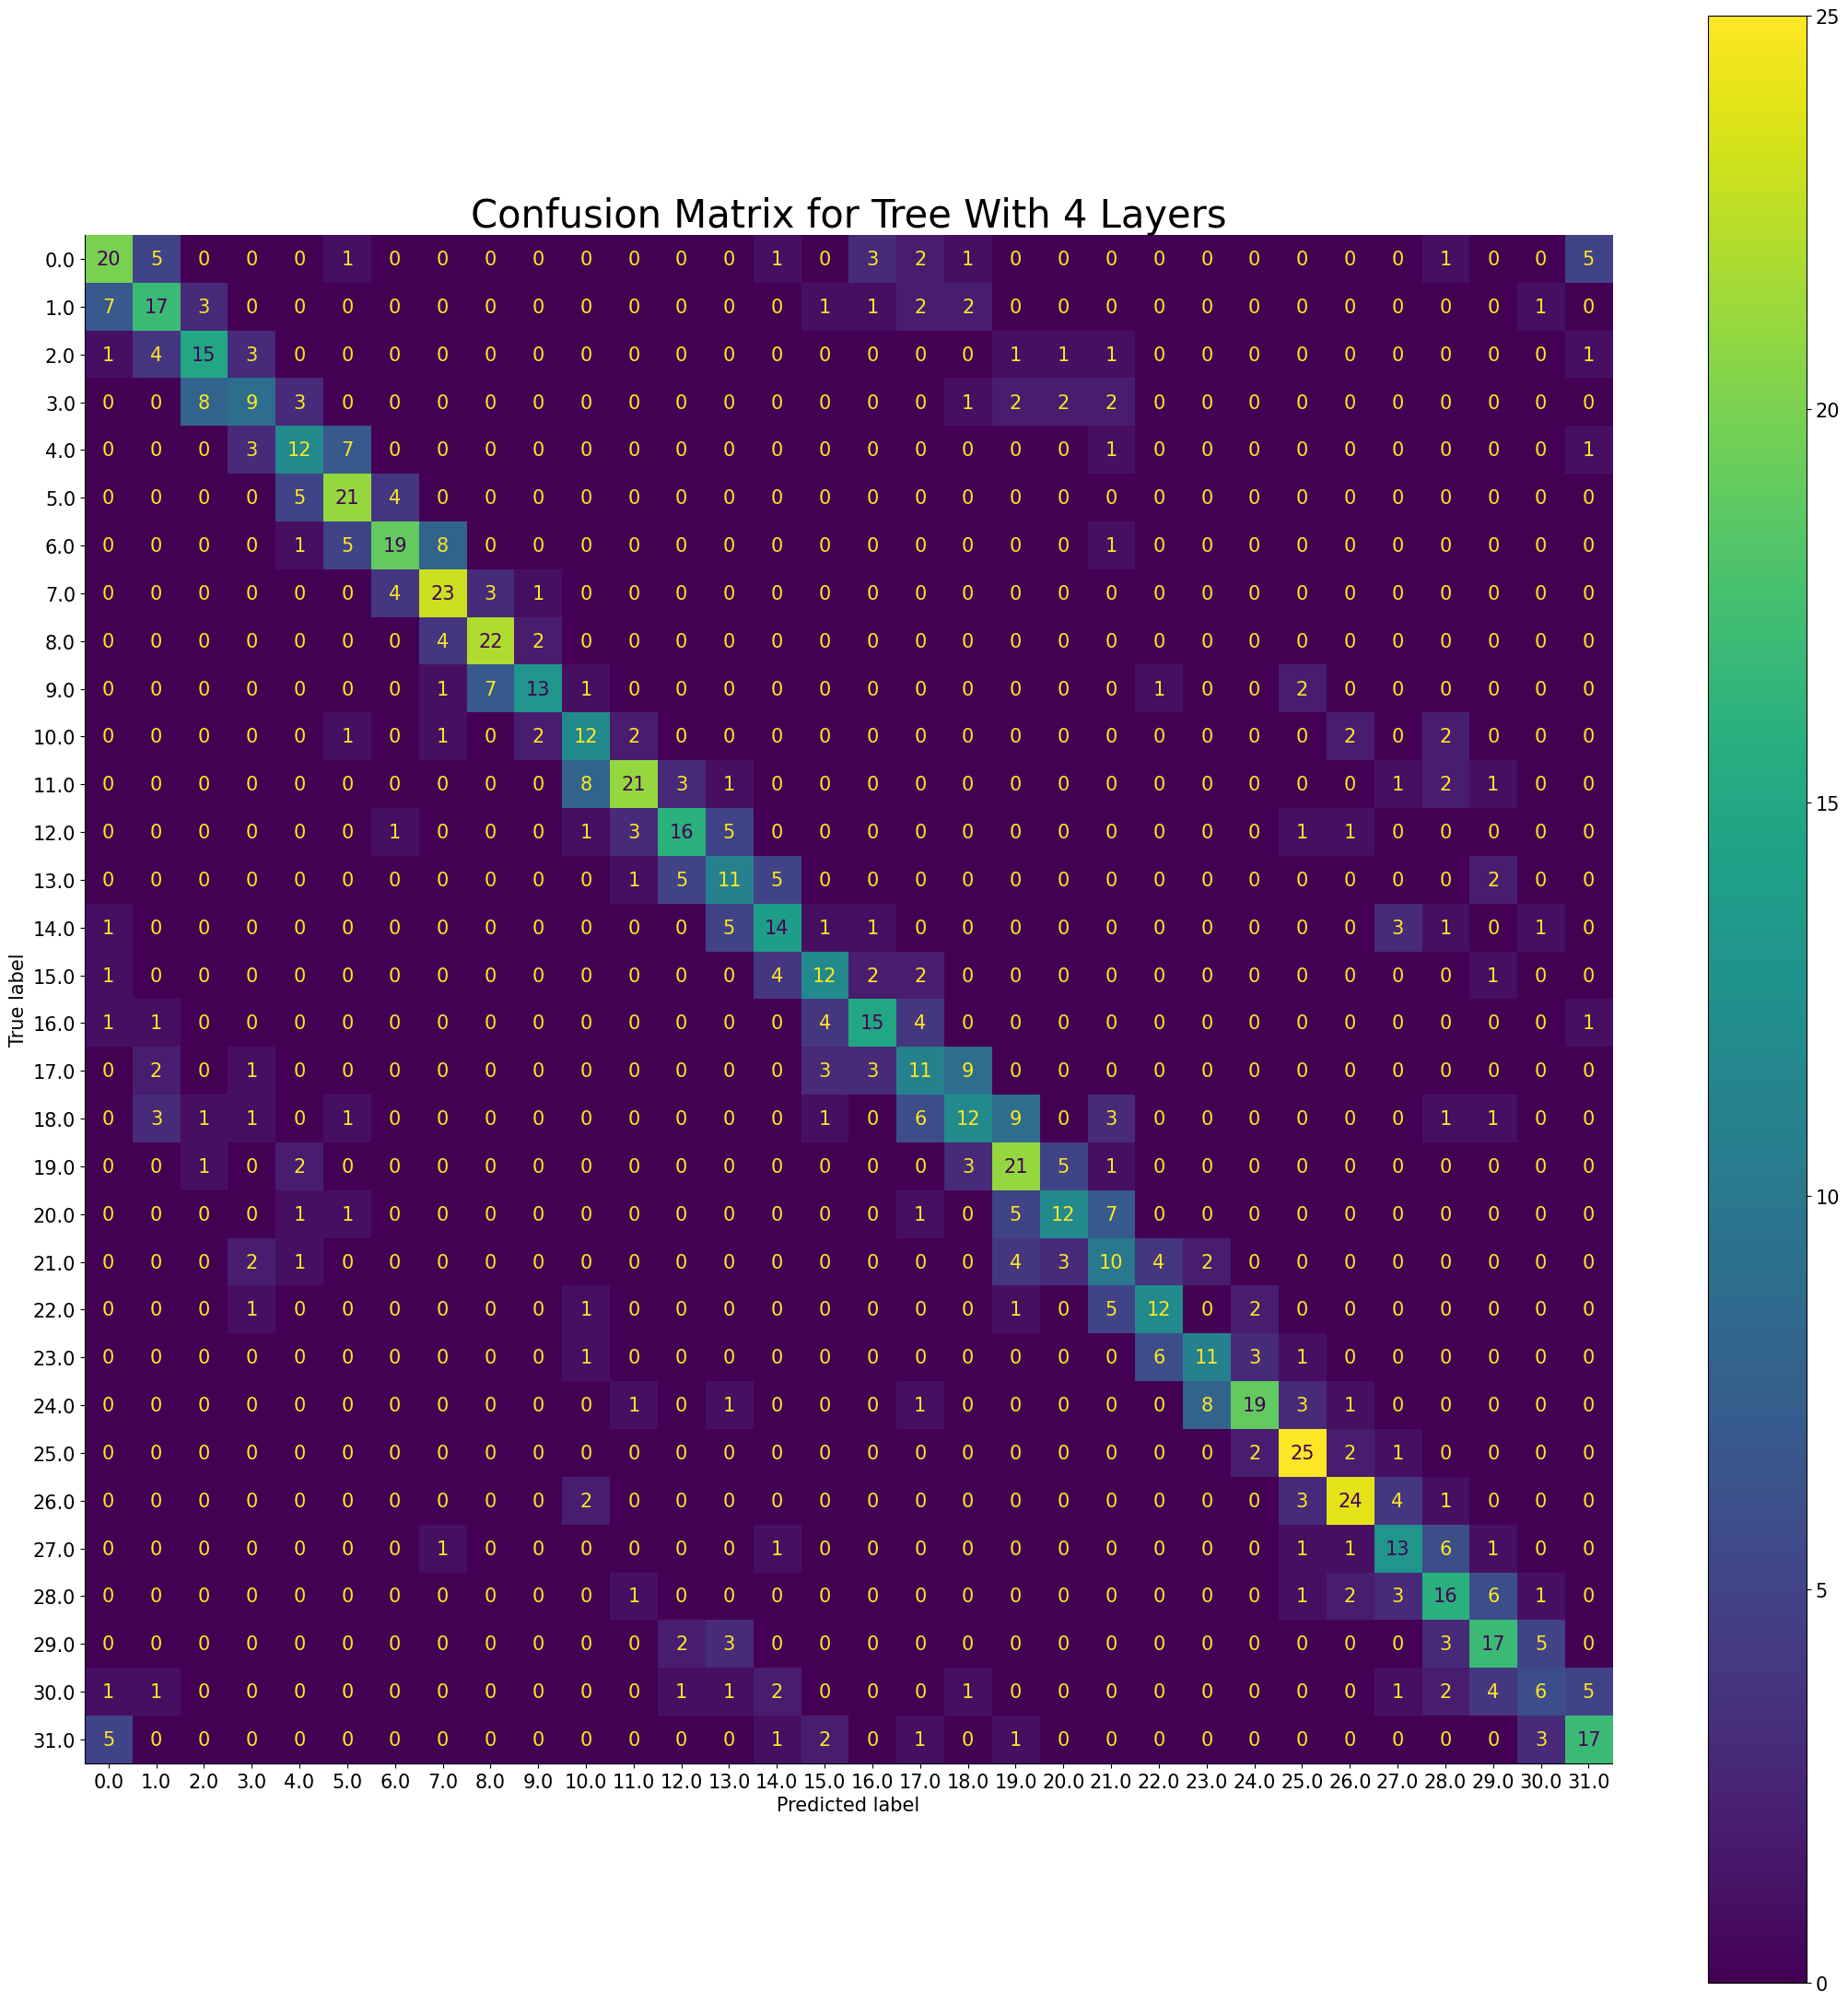

In [20]:
fig, ax = plt.subplots(figsize=(22, 22))
disp = get_confusion_matrix(X_4_train, y_4_train, X_4_test, y_4_test)
disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='horizontal')
plt.title('Confusion Matrix for Tree With 4 Layers', fontsize=30)
plt.show()

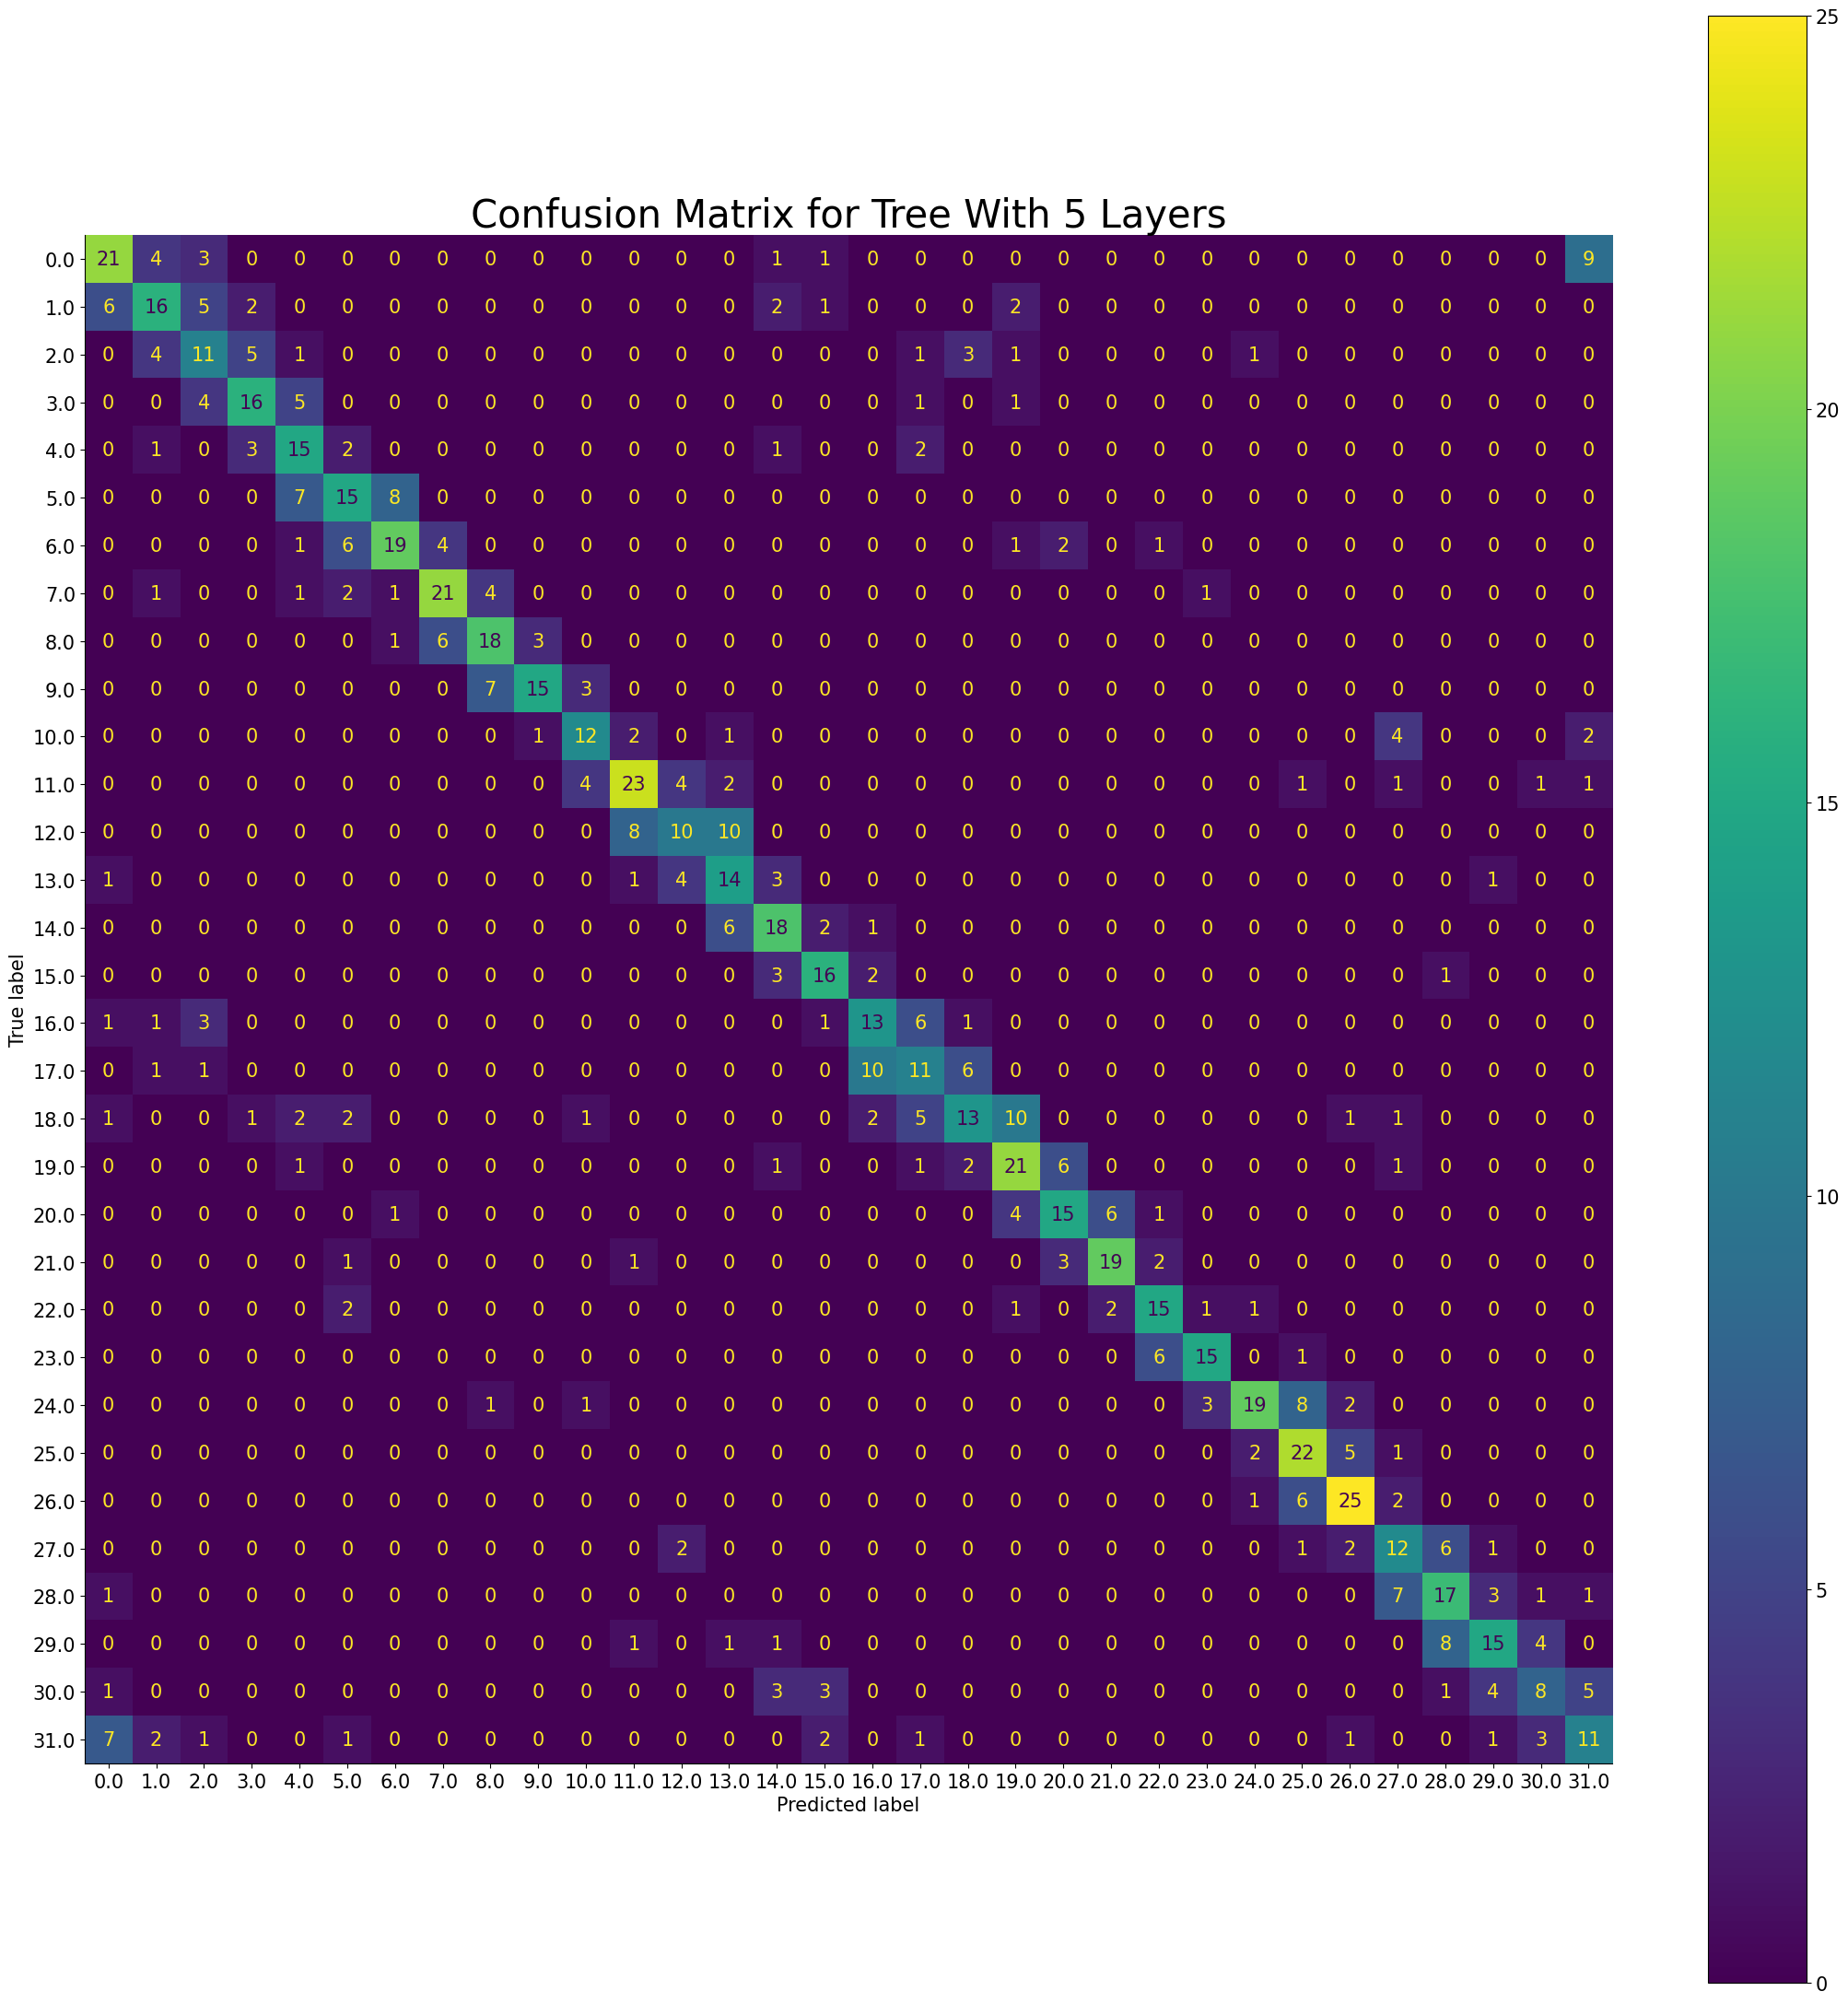

In [21]:
fig, ax = plt.subplots(figsize=(22, 22))
disp = get_confusion_matrix(X_5_train, y_5_train, X_5_test, y_5_test)
disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='horizontal')
plt.title('Confusion Matrix for Tree With 5 Layers', fontsize=30)
plt.show()